In [1]:
### Can't plot in BNG, because tilemapbase just uses WM (and this is needed to supply basemap)
# Can plot without a basemap though

In [2]:
def find_rainfall_core(df, duration):    

    duration =4
    window_length= int(duration*2)

    df['is_dry'] = df['precipitation'] < 0.1
    # Calculate the rolling sum of precipitation for each 2-hour window
    df['Rolling_Sum'] = df['precipitation'].rolling(window=window_length).sum()

    # Find the index of the maximum total rainfall within a 2-hour window
    max_rainfall_end_index = df['Rolling_Sum'].idxmax()

    # Find the position of max_rainfall_end_index in the DataFrame's index
    max_rainfall_end_pos = df.index.get_loc(max_rainfall_end_index)

    # Calculate the start position of the 2-hour window with the most rainfall
    # This accounts for 3 periods before the max index, as the max index is inclusive
    max_rainfall_start_pos = max(0, max_rainfall_end_pos - window_length)  # Ensure it doesn't go below the DataFrame's range

    # Extract the 2-hour window using iloc
    max_rainfall_window = df.iloc[max_rainfall_start_pos:max_rainfall_end_pos].copy()

    # Check it's one independent event (e.g. doesnt contain a dry period longer than Tb0)
    max_rainfall_window['consecutive_dry'] = 0

    # Start the count of consecutive dry periods
    consecutive_dry_count = 0

    # # Iterate through the DataFrame rows to count consecutive dry periods, excluding the current row
    # max_rainfall_window.reset_index(inplace=True, drop=True)
    for i in range(1, len(max_rainfall_window)):
        if max_rainfall_window.at[max_rainfall_window.first_valid_index()+i - 1, 'is_dry']:
            consecutive_dry_count += 1
        else:
            consecutive_dry_count = 0
        max_rainfall_window.at[max_rainfall_window.first_valid_index()+i, 'consecutive_dry'] = consecutive_dry_count

    if np.nanmax(max_rainfall_window['consecutive_dry'])>Tb0:
        print('2 events')
    return max_rainfall_window

def search1(max_rainfall_window):
    ######## Backwards
    # Find the ending index of max_rainfall_window
    end_index_position = df.index.get_loc(max_rainfall_window.last_valid_index())

    # Initialize a variable to keep track of the current position being checked
    current_position = end_index_position + 1  # Start from the row just after the max_rainfall_window

    # Iterate forward through the DataFrame from the end of the max_rainfall_window
    while current_position < len(df):
        # Get the row at the current position
        row_by_position_df = df.iloc[current_position:current_position+1]
        #print(f"Checking row at position {current_position}:")
        #print(row_by_position_df)

        # Check if the row is dry
        if row_by_position_df['is_dry'].values[0] == False:
            #print('Row is dry. Including it in the window.')
            if row_by_position_df['precipitation'].values[0]>0.2:
                # If the row is dry, append it to max_rainfall_window
                max_rainfall_window = pd.concat([max_rainfall_window, row_by_position_df], axis=0)
        else:
            #print("Row is wet. Stopping the search.")
            # If the row is wet, stop the search
            break

        # Move to the next row to check
        current_position += 1
    max_rainfall_window

    ######## Forewards
    # Find the starting index of max_rainfall_window
    start_index = max_rainfall_window.first_valid_index()

    # Initialize a variable to keep track of the current position being checked
    current_position = start_index - 1  # Start from the row just before the max_rainfall_window

    # Iterate backwards through the DataFrame from the start of the max_rainfall_window
    while current_position >= 0:
        # Get the row at the current position
        row_by_position_df = df.iloc[current_position:current_position+1]
        #print(f"Checking row at position {current_position}:")
        #print(row_by_position_df)

        # Check if the row is dry
        if row_by_position_df['is_dry'].values[0] == False:
            if row_by_position_df['precipitation'].values[0] >0.2:
                # If the row is dry, append it to max_rainfall_window
                max_rainfall_window = pd.concat([max_rainfall_window, row_by_position_df], axis=0)
            #print('Row is dry. Including it in the window.')
        else:
            # print("Row is wet. Stopping the search.")
            # If the row is wet, stop the search
            break

        # Move to the next row to check
        current_position -= 1
    return max_rainfall_window
    

def search2(max_rainfall_window):
    #### Foreward search
    # Find the ending index of max_rainfall_window
    end_index_position = df.index.get_loc(max_rainfall_window.last_valid_index())

    # Initialize a variable to keep track of the current position being checked
    current_position = end_index_position + 1  # Start from the row just after the max_rainfall_window

    # Iterate forward through the DataFrame from the end of the max_rainfall_window
    while current_position < len(df):
        # Get the row at the current position
        row_by_position_df = df.iloc[current_position:current_position+2]
        #print(f"Checking row at position {current_position}:")
        #print(row_by_position_df)

        if row_by_position_df['precipitation'].sum() > 0.4:
            max_rainfall_window = pd.concat([max_rainfall_window, row_by_position_df], axis=0)
        else:
            #print("Row is wet. Stopping the search.")
            # If the row is wet, stop the search
            break

        # Move to the next row to check
        current_position += 2
    
    #### Backward search
    # Find the starting index of max_rainfall_window
    start_index = max_rainfall_window.first_valid_index()

    # Initialize a variable to keep track of the current position being checked
    current_position = start_index - 1  # Start from the row just before the max_rainfall_window

    # Iterate backwards through the DataFrame from the start of the max_rainfall_window
    while current_position >= 0:
        # Get the row at the current position
        row_by_position_df = df.iloc[current_position:current_position+1]
        #print(f"Checking row at position {current_position}:")
        #print(row_by_position_df)

        # Check if the row is dry
        if row_by_position_df['precipitation'].sum() > 0.4:
            max_rainfall_window = pd.concat([row_by_position_df, max_rainfall_window], axis=0)
            #print('Row is dry. Including it in the window.')
        else:
            # print("Row is wet. Stopping the search.")
            # If the row is wet, stop the search
            break

        # Move to the next row to check
        current_position -= 2    
        
    return max_rainfall_window

def search3(max_rainfall_window):
    
    '''
    Searches for any rainfall values within Tbo of the last rainfall value currently included, 
    and if any of these have a rainfall value >1mm/hr then the intervening values up to the occurrence of this value 
    are included
    '''
    
    #### Backwards search
    start_index = max_rainfall_window.first_valid_index()
    backward_position = start_index - Tb0*2

    while backward_position >= 0:
        backward_slice = df.iloc[backward_position:start_index]
        if (backward_slice['precipitation'] > 1).any():
            first_true_index = (backward_slice['precipitation'] > 1).idxmax()
            max_rainfall_window = pd.concat([df.loc[first_true_index:start_index-1], max_rainfall_window], axis=0)
            start_index = first_true_index - Tb0*2  # Update the start index for further searches if needed
            backward_position = start_index - Tb0*2  # Update the backward search position
        else:
            break  # Exit the loop if no such condition is met

    ### Foreward search: from the end of the existing max_rainfall_window
    end_index = max_rainfall_window.last_valid_index()

    while end_index < len(df):
        # Tracks the current position of where the forward search is starting from
        # e.g. (the row afer the max_rainfall_window)
        forward_search_start_position = end_index + 1
        # and ending from (e.g. 2*Tb0 after where it starts)
        forward_search_end_position = min(len(df), forward_search_start_position + (Tb0*2) + 1)  # Define the limit for forward search
        # Get the forward slice
        forward_slice = df.iloc[forward_search_start_position:forward_search_end_position]
        # Check for rows meeting the condition (> 1 mm/hr)
        condition_met = forward_slice['precipitation'] > 1
        if condition_met.any():
            # Identify the last index where the condition is True
            last_true_index = condition_met[condition_met].index[-1]
            rows_to_add = df.loc[end_index+1:last_true_index]
            max_rainfall_window = pd.concat([max_rainfall_window, rows_to_add], axis=0)
        else:
            break

        # Update the end index
        end_index = max_rainfall_window.last_valid_index()
    
    return max_rainfall_window

In [3]:
def find_cornerpoint_coordinates_obs (cube):
    '''
    Description
    ----------
        Using a cube of lat, longs in rotated pole and associated values the function
        creates new 2D lat, lon and data arrays in which the data values are associated
        with a point at the bottom left of each grid cell, rather than the middle.
    Parameters
    ----------
        cube: Iris Cube
            A cube containing only latitude and longitude dimensions
            In rotated pole coordinates so that...are constant..
    Returns
    -------
        lats_wm_midpoints_2d : array
            A 2d array of the mid point latitudes
        lons_wm_midpoints_2d : array
            A 2d array of the mid point longitudes
        
    '''
    
    # Extract lats and longs in rotated pol as a 2D array
    lats_1d = cube.coord('projection_y_coordinate').points
    lons_1d = cube.coord('projection_x_coordinate').points
    
    # Find the distance between each lat/lon and the next lat/lon
    # Divide this by two to get the distance to the half way point
    lats_differences_half = np.diff(lats_1d)/2
    lons_differences_half = np.diff(lons_1d)/2
    
    # Create an array of lats/lons at the midpoints
    lats_midpoints_1d = lats_1d[1:] - lats_differences_half
    lons_midpoints_1d = lons_1d[1:] - lons_differences_half
    
    # Convert to 2D
    lons_midpoints_2d, lats_midpoints_2d = np.meshgrid(lons_midpoints_1d, lats_midpoints_1d)

    # Convert to web mercator
    transformer = Transformer.from_crs("EPSG:27700", "EPSG:3857", always_xy=True)
    lons_wm_midpoints_2d, lats_wm_midpoints_2d = transformer.transform(lons_midpoints_2d, lats_midpoints_2d)
    
    # Convert to 1d     
    lons_wm_midpoints_1d = lons_wm_midpoints_2d.reshape(-1)
    lats_wm_midpoints_1d = lats_wm_midpoints_2d.reshape(-1)
    
    # Remove same parts of data
    data = cube.data
    data_midpoints = data[1:,1:]
    
    return (lats_wm_midpoints_2d, lons_wm_midpoints_2d)

def calculate_bounding_box(latitude, longitude, distance_km):
    # Earth's radius in kilometers
    earth_radius_km = 6371.01

    # Calculate the change in latitude for the given distance
    delta_lat = distance_km / earth_radius_km * (180 / 3.141592653589793)

    # Calculate the change in longitude, adjusting for the latitude
    delta_lon = distance_km / (earth_radius_km * cos(radians(latitude))) * (180 / 3.141592653589793)

    # Calculate bounding box coordinates
    min_lat = latitude - delta_lat
    max_lat = latitude + delta_lat
    min_lon = longitude - delta_lon
    max_lon = longitude + delta_lon

    return min_lat, max_lat, min_lon, max_lon

def create_geodataframe_from_bbox(min_lat, max_lat, min_lon, max_lon):
    # Create a Polygon from the bounding box coordinates
    bbox_polygon = Polygon([(min_lon, min_lat), (min_lon, max_lat), 
                            (max_lon, max_lat), (max_lon, min_lat), 
                            (min_lon, min_lat)])
    
    # Create a GeoDataFrame with the Polygon
    gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[bbox_polygon])
    
    return gdf


def find_position_obs (concat_cube, rain_gauge_lat, rain_gauge_lon):
    lat_length = concat_cube.shape[0]
    lon_length = concat_cube.shape[1]
    
    ### Rain gauge data 
    # Convert WGS84 coordinate to BNG
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700", always_xy=True)
    # Use the transformer to convert longitude and latitude to British National Grid coordinates
    rain_gauge_lon_bng, rain_gauge_lat_bng = transformer.transform(rain_gauge_lon, rain_gauge_lat)
    
    # Create as a list
    rain_gauge_point = [('grid_latitude', rain_gauge_lat_bng), ('grid_longitude', rain_gauge_lon_bng)]
                 
    ### Model data
    # Create a list of all the tuple pairs of latitude and longitudes
    locations = list(itertools.product(concat_cube.coord('projection_y_coordinate').points,
                                       concat_cube.coord('projection_x_coordinate').points))
    
    # Find the index of the nearest neighbour of the rain gague location point in the list of locations present in concat_cube
    tree = spatial.KDTree(locations)
    closest_point_idx = tree.query([(rain_gauge_point[0][1], rain_gauge_point[1][1])], k =1)[1][0]
    
    # Create a list of all the tuple positions
    indexs_lst = []
    for i in range(0,lat_length):
        for j in range(0,lon_length):
            # Print the position
            #print(i,j)
            indexs_lst.append((i,j))
              
    ######## Check by plotting 
    # Get cube containing one hour worth of data
    hour_uk_cube = concat_cube

    # Set all the values to 0
    test_data = np.full((hour_uk_cube.shape),0,dtype = int)
    # Set the values at the index position fond above to 1
    test_data[indexs_lst[closest_point_idx][0],indexs_lst[closest_point_idx][1]] = 1
    # Mask out all values that aren't 1
    test_data = ma.masked_where(test_data<1,test_data)
    
    # Set the dummy data back on the cube
    hour_uk_cube.data = test_data
    
    # Find cornerpoint coordinates (for use in plotting)
    lats_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[0]
    lons_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[1]
    
    # Trim the data timeslice to be the same dimensions as the corner coordinates
    hour_uk_cube = hour_uk_cube[1:,1:]
    test_data = hour_uk_cube.data

    # Create location in web mercator for plotting
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    lon_rain_gauge_wm, lat_rain_gauge_wm = transformer.transform(rain_gauge_lon,rain_gauge_lat)
        
    # Create bounding box to centre the map on
    min_lat, max_lat, min_lon, max_lon = calculate_bounding_box(rain_gauge_lat, rain_gauge_lon, distance_km =30)
    gdf_bbox = create_geodataframe_from_bbox(min_lat, max_lat, min_lon, max_lon)
    gdf_bbox_web_mercator = gdf_bbox.to_crs(epsg=3857)
        
    # Create a colormap
    cmap = matplotlib.colors.ListedColormap(['red'])
    
    fig, ax = plt.subplots(figsize=(15,15))
    extent = tilemapbase.extent_from_frame(gdf_bbox_web_mercator)
    plot = plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=500)
    plot =plotter.plot(ax)
    # # Add edgecolor = 'grey' for lines
    plot =ax.pcolormesh(lons_cornerpoints, lats_cornerpoints, test_data,
          linewidths=0.4, alpha = 1, cmap = cmap, edgecolors = 'grey')
    plot = ax.xaxis.set_major_formatter(plt.NullFormatter())
    plot = ax.yaxis.set_major_formatter(plt.NullFormatter())
    #plot =leeds_at_centre_gdf.plot(ax=ax, categorical=True, alpha=1, edgecolor='black', color='none', linewidth=2)
    plt.plot(lon_rain_gauge_wm, lat_rain_gauge_wm, 'o', color='black', markersize = 10)     
    plt.show()
     
    print(indexs_lst[closest_point_idx][0],indexs_lst[closest_point_idx][1])    
    return closest_point_idx, locations[closest_point_idx], (indexs_lst[closest_point_idx][0],indexs_lst[closest_point_idx][1])

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
warnings.filterwarnings("ignore", category =UserWarning,)

from pyproj import Transformer
import numpy as np
import pandas as pd
import iris
import glob
import sys
import os
import cartopy.crs as ccrs
import itertools
from scipy import spatial
import numpy.ma as ma
import tilemapbase
import iris.plot as iplt
from math import cos, radians
import geopandas as gpd
from shapely.geometry import Polygon

In [5]:
# Set up path to root directory
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

### Get model data: 30 mins data for one ensemble member 2001-2019

In [6]:
filenames = []
em = 'bc005'
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)

for yr in range(2001,2020):
    general_filename = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_every30mins/2.2km/2002_2020/{em}/{yr}_maskedcube.nc'
    filenames.append(general_filename)
filenames    

# ### Load in the data
monthly_cubes_list = iris.load(filenames, in_jja)
print(len(monthly_cubes_list))    
model_cube = monthly_cubes_list.concatenate_cube()   

19


### Get gauge data

In [7]:
# Replace 'your_file_path.txt' with the path to your text file
file_path = '/nfs/a319/gy17m2a/PhD/datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt'

# Read the CSV data into a DataFrame
tbo_vals = pd.read_csv(file_path)

gauge1 = tbo_vals.iloc[1:2]
gauge1['Lat'].values[0]
gauge1['Critical_interarrival_time']

1    9.0
Name: Critical_interarrival_time, dtype: float64

### Find grid cell containing the gauge1 (needs BNG version because of projection issues)

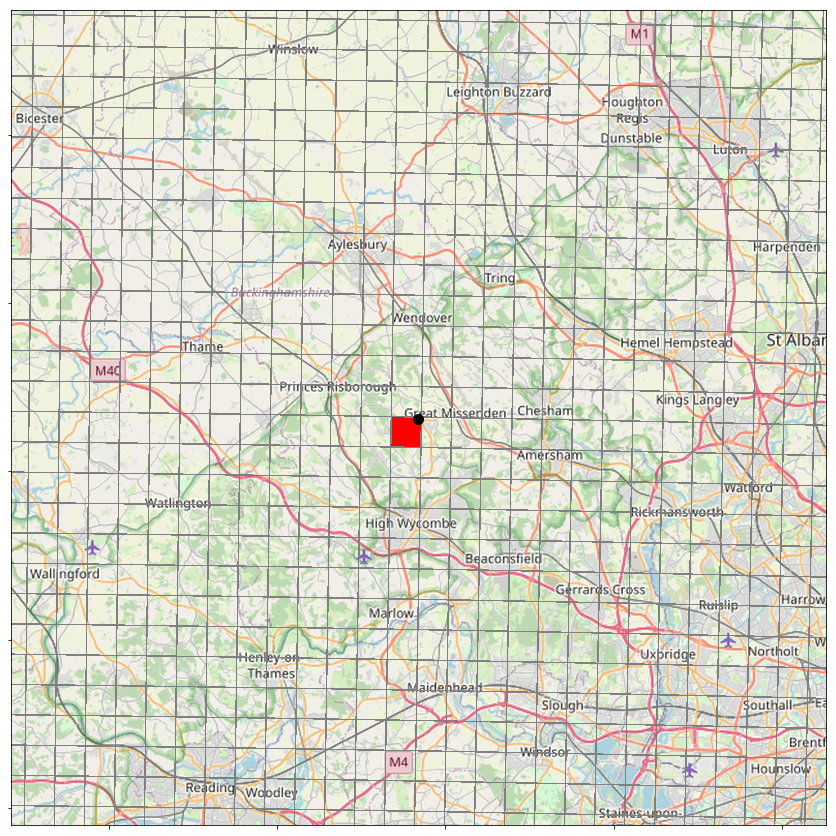

89 340


In [8]:
general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km_bng/{em}/2002_2020/bng_{em}a.pr200508*'
cube = iris.load(general_filename)[0]
cube_onets = cube[1,:,:]
closest_point_idx, closest_point, idx_2d = find_position_obs(cube_onets,gauge1['Lat'].values[0], gauge1['Lon'].values[0] )

### Get model data just for the cell with the gauge inside it

In [9]:
# data = model_cube[:,89,340].data
# df= pd.DataFrame({'precipitation':data})

# Find independent rainfall events for the grid cell

### Extract Tb0 for this gauge (from Roberto's dataset)

In [10]:
Tb0 = gauge1['Critical_interarrival_time'].values[0]

## Convert to functions and apply to each year of the data individually
What this does:  
    -- For each duration it finds the timeseries in each year which produces the maximum value   
    -- Saves these to a list  
    -- Create a dictionary containing durations as keys, and lists of AMAX producing timeseries as the items  
    
    
THINGS TO CONSIDER:  
-- Are we just looking at the timeseries which produced the AMAX at that duration, or the whole event?  
-- Do we also need to loop across EMs?

In [11]:
duration =4 
yr = 2006
# Get cube for this year, at the cell containing the gauge
general_filename = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_every30mins/2.2km/2002_2020/{em}/{yr}_maskedcube.nc'
cube = iris.load(general_filename)[0]
# This gauge
data = cube[:,89,340].data
# Data as dataframe
df= pd.DataFrame({'precipitation':data})

In [13]:
cube

<iris 'Cube' of stratiform_rainfall_flux / (mm/hour) (time: 4320; grid_latitude: 519; grid_longitude: 423)>

### Other method

In [34]:
rainfall_core = find_rainfall_core(df, duration=4)
rainfall_core_after_search1 = search1(rainfall_core)
rainfall_core_after_search2 = search2(rainfall_core_after_search1)
rainfall_core_after_search3 = search2(rainfall_core_after_search2)
rainfall_core_after_search3

,precipitation,is_dry,Rolling_Sum,consecutive_dry
1861,5.866917e-07,True,0.000009,0.0
1862,3.919653e+00,False,3.919661,1.0
1863,1.751404e+00,False,5.671063,0.0
1864,5.697421e-01,False,6.240803,0.0
1865,4.349268e+00,False,10.590071,0.0
1866,8.150616e+00,False,18.740685,0.0
1867,7.847093e+00,False,26.587777,0.0
1868,7.659128e-01,False,27.353689,0.0
1869,2.334548e-01,False,27.587143,NaN


### ???

In [164]:
# # Dictionary to store results for all different durations
# # all_durations = {}

# for duration in [2,6,8,10,12,14]:
#     this_duration_ls =[]
#     for yr in range(2001,2020):
#         print(yr)
#         # Get cube for this year, at the cell containing the gauge
#         general_filename = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_every30mins/2.2km/2002_2020/{em}/{yr}_maskedcube.nc'
#         cube = iris.load(general_filename)[0]
#         # This gauge
#         data = cube[:,89,340].data
#         # Data as dataframe
#         df= pd.DataFrame({'precipitation':data})
#         # Find independent events
#         rainfall_events = find_independent_events(df, Tb0)
#         print(len(rainfall_events))
#         # Find event with maximum rainfall for this duration
#         max_val, max_df, max_idx = find_max_for_this_duration(rainfall_events, duration = duration)
#         # Add to list for this duration
#         this_duration_ls.append(max_df)
#     # Add to dict
#     all_durations[duration] = this_duration_ls

## Check plotting for patterns
### THIS CURRENTLY DOESNT MAKE LOADS OF SENSE AS THE EVENTS AREN'T ALL THE SAME LENGTH

In [ ]:
### PLotting all events, not just of a particular duration (doesnt make sense as they are all different lengths)

In [98]:
# # this_duration_ls[0]["precipitation"].sum()
# plt.figure(figsize=(12, 6))
# for duration in [4]:
#     this_duration_ls =[]
#     for yr in range(2001,2003):
#         print(yr)
#         # Get cube for this year, at the cell containing the gauge
#         general_filename = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_every30mins/2.2km/2002_2020/{em}/{yr}_maskedcube.nc'
#         cube = iris.load(general_filename)[0]
#         data = cube[:,89,340].data
#         df= pd.DataFrame({'precipitation':data})

#         # Find independent events
#         rainfall_events = find_independent_events(df, Tb0)
#         for rainfall_event in rainfall_events:
#             rainfall_event['event_data'].reset_index(inplace=True, drop=True)
#             plt.plot(rainfall_event['event_data'].index, rainfall_event['event_data']['precipitation'], marker='o', linestyle='-')

# plt.title('Precipitation Over Time')
# plt.xlabel('Time (30-minute intervals)')
# plt.ylabel('Precipitation (mm/hr)')
# plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
# plt.grid(True)  # Optional: Adds a grid for easier visualization
# plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area
# plt.show()

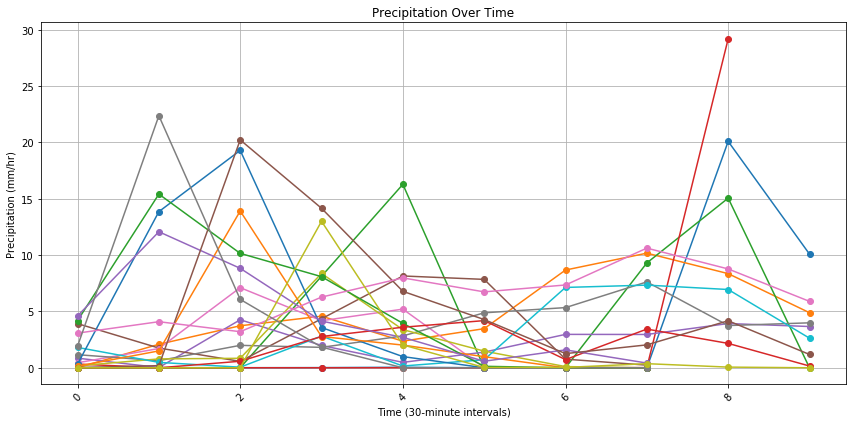

In [86]:
# this_duration_ls[0]["precipitation"].sum()
plt.figure(figsize=(12, 6))
for rainfall_event in all_durations[4]:
    rainfall_event.reset_index(inplace=True, drop=True)
    # Plotting
    plt.plot(rainfall_event.index, rainfall_event['precipitation'], marker='o', linestyle='-')

plt.title('Precipitation Over Time')
plt.xlabel('Time (30-minute intervals)')
plt.ylabel('Precipitation (mm/hr)')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)  # Optional: Adds a grid for easier visualization
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area
plt.show()

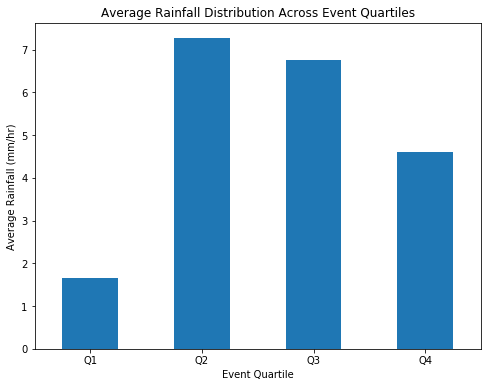

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Assuming event_list is your list of DataFrames, each with 'precipitation' for 30-min intervals

# Step 1: Normalize Each Event to 4 intervals (quartiles)
normalized_events = []
for event_df in all_durations[2]:
    # Create a normalized scale (0 to 1) for the event duration
    x_old = np.linspace(0, 1, num=len(event_df))
    y_old = event_df['precipitation'].values
    # Create a function to interpolate rainfall data to 4 points (quartiles)
    f = interp1d(x_old, y_old, kind='linear')
    x_new = np.linspace(0, 1, num=4)  # Target 4 intervals for normalization
    y_new = f(x_new)  # Interpolated rainfall values
    normalized_events.append(y_new)

# Step 2: Aggregate Rainfall Data Across Events
# Convert list of arrays to a DataFrame for easy calculation
agg_df = pd.DataFrame(normalized_events, columns=['Q1', 'Q2', 'Q3', 'Q4'])
aggregate_rainfall = agg_df.mean()

# Step 3: Analyze the Temporal Distribution
# Plotting the aggregated rainfall data
plt.figure(figsize=(8, 6))
aggregate_rainfall.plot(kind='bar')
plt.title('Average Rainfall Distribution Across Event Quartiles')
plt.xlabel('Event Quartile')
plt.ylabel('Average Rainfall (mm/hr)')
plt.xticks(rotation=0)
plt.show()


In [120]:
all_durations.keys()

dict_keys([4, 2, 6, 8, 10, 12, 14])

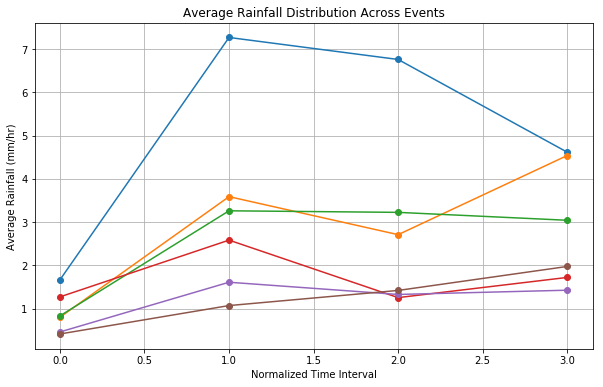

In [123]:
n_breaks = 4

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Example setup for 'event_list', a list of DataFrames
# Each DataFrame represents a rainfall event with 'precipitation' for each 30-minute interval

# Placeholder for your actual event list
event_list = [pd.DataFrame({'precipitation': np.random.rand(np.random.randint(8, 12)) * np.random.randint(1, 4)}) for _ in range(10)]


plt.figure(figsize=(10, 6))

for duration in [2, 4,6, 8,10,12]:
    # Normalize Each Event to 8 intervals
    normalized_events = []
    for event_df in all_durations[duration]:
        # Interpolate or directly split the precipitation data of each event to 8 intervals
        if len(event_df) > n_breaks:
            x_old = np.linspace(0, 1, num=len(event_df))
            y_old = event_df['precipitation'].values
            f = interp1d(x_old, y_old, kind='linear')
            x_new = np.linspace(0, 1, num=n_breaks)  # Target 8 intervals for normalization
            y_new = f(x_new)  # Interpolated rainfall values
        else:
            y_new = event_df['precipitation'].values  # No need to interpolate if already 8 steps
        normalized_events.append(y_new)

    # Aggregate Rainfall Data Across Events
    agg_df = pd.DataFrame(normalized_events)
    aggregate_rainfall = agg_df.mean()

    # Analyze the Temporal Distribution

    aggregate_rainfall.plot(marker='o', linestyle='-')
plt.title('Average Rainfall Distribution Across Events')
plt.xlabel('Normalized Time Interval')
plt.ylabel('Average Rainfall (mm/hr)')
# plt.xticks(ticks=np.arange(8), labels=[f'Part {i+1}' for i in range(8)])
plt.grid(True)
plt.show()
